# Correlating FERC and EIA Plants

FERC and EIA report plants somewhat differently. In order to use the two datasets in tandem (e.g. to use FERC Form 1 O&M costs alongside EIA 923 boiler and generator level fuel consumption and net generation) we need to link the two sets of plants together.

There are several variables which are reported by both FERC and EIA, or which are derivable from reported values. These include:
* Yearly total heat content of fuel consumed by plant and by fuel.
* Yearly total cost of fuel consumed by plant and by fuel.
* Yearly net electricity generation by plant.

Given these data, it may be possible to infer associations between a given collection of EIA boilers and generators, and the corresponding plant-level data from FERC.

This notebook looks at the correlations between the above listed variables for the FERC and EIA datasets as a whole, first for the simplest plants -- those with only a single unit reported in both FERC and EIA, and grouped under a common PUDL plant ID.

Given high correlations between these variables, we then look at the correlations within individual simple plants -- can we effectively differentiate between a good and a bad plant-level match, even for the simple plants, given just a handful of years for each one?

If we can identify good and bad matches for simple plants, then we can move on to more complicated types of plants, where we may need to select some subset of plants, boilers, and generators to associate with individual FERC plants that we have grouped under a single PUDL plant ID, based on how well the variables for different collections of infrastructure correlate.

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..','..')))
from pudl import pudl, ferc1, eia923, settings, constants
from pudl import models, models_ferc1, models_eia923
from pudl import clean_eia923, clean_ferc1, clean_pudl
from pudl import analysis
import numpy as np
import pandas as pd
import sqlalchemy as sa
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
%load_ext autoreload
%autoreload
pudl_engine = pudl.db_connect_pudl()

In [26]:
pt = models.PUDLBase.metadata.tables
utilities_ferc1 = pudl_tables['utilities_ferc1']
utilities_eia923 = pudl_tables['utilities_eia923']
plants_ferc1 = pudl_tables['plants_ferc1']
plants_eia923 = pudl_tables['plants_eia923']
plants_pudl = pudl_tables['plants']
util_plant_assn = pudl_tables['util_plant_assn']
frc_eia923 = pudl_tables['fuel_receipts_costs_eia923']
gf_eia923 = pudl_tables['generation_fuel_eia923']
fuel_ferc1 = pudl_tables['fuel_ferc1']
steam_ferc1 = pudl_tables['plants_steam_ferc1']

In [29]:
pt['plants_ferc1']

Table('plants_ferc1', MetaData(bind=None), Column('respondent_id', Integer(), ForeignKey('utilities_ferc1.respondent_id'), table=<plants_ferc1>, primary_key=True, nullable=False), Column('plant_name', String(), table=<plants_ferc1>, primary_key=True, nullable=False), Column('plant_id_pudl', Integer(), ForeignKey('plants.id'), table=<plants_ferc1>, nullable=False), schema=None)

# Assembling useful FERC & EIA DataFrames
We need to pull together information from several PUDL database tables -- especially IDs -- so that we can link together information across the datasets.  These functions each perform a select and hand back a useful dataframe.

In [3]:
def get_fuel_ferc1_df():
    fuel_ferc1_select = sa.sql.select([
        fuel_ferc1.c.report_year,
        utilities_ferc1.c.respondent_id,
        utilities_eia923.c.operator_id,
        utilities_ferc1.c.util_id_pudl,
        utilities_ferc1.c.respondent_name,
        plants_ferc1.c.plant_id_pudl,
        plants_eia923.c.plant_id,
        fuel_ferc1.c.plant_name,
        fuel_ferc1.c.fuel,
        fuel_ferc1.c.fuel_qty_burned,
        fuel_ferc1.c.fuel_avg_mmbtu_per_unit,
        fuel_ferc1.c.fuel_cost_per_unit_burned,
        fuel_ferc1.c.fuel_cost_per_unit_delivered,
        fuel_ferc1.c.fuel_cost_per_mmbtu,
        fuel_ferc1.c.fuel_cost_per_mwh,
        fuel_ferc1.c.fuel_mmbtu_per_mwh]).\
        where(sa.sql.and_(
            utilities_ferc1.c.respondent_id == fuel_ferc1.c.respondent_id,
            plants_ferc1.c.respondent_id == fuel_ferc1.c.respondent_id,
            plants_ferc1.c.plant_name == fuel_ferc1.c.plant_name,
            utilities_eia923.c.util_id_pudl == utilities_ferc1.c.util_id_pudl,
            plants_eia923.c.plant_id_pudl == plants_ferc1.c.plant_id_pudl))

    return(pd.read_sql(fuel_ferc1_select, pudl_engine))

In [4]:
def get_steam_ferc1_df():
    steam_ferc1_select = sa.sql.select([
        steam_ferc1.c.report_year,
        utilities_ferc1.c.respondent_id,
        utilities_eia923.c.operator_id,
        utilities_ferc1.c.util_id_pudl,
        utilities_ferc1.c.respondent_name,
        plants_ferc1.c.plant_id_pudl,
        plants_eia923.c.plant_id,
        steam_ferc1.c.plant_name,
        steam_ferc1.c.total_capacity_mw,
        steam_ferc1.c.net_generation_mwh,
        steam_ferc1.c.expns_operations,
        steam_ferc1.c.expns_fuel,
        steam_ferc1.c.expns_coolants,
        steam_ferc1.c.expns_steam,
        steam_ferc1.c.expns_steam_other,
        steam_ferc1.c.expns_transfer,
        steam_ferc1.c.expns_electric,
        steam_ferc1.c.expns_misc_power,
        steam_ferc1.c.expns_rents,
        steam_ferc1.c.expns_allowances,
        steam_ferc1.c.expns_engineering,
        steam_ferc1.c.expns_structures,
        steam_ferc1.c.expns_boiler,
        steam_ferc1.c.expns_plants,
        steam_ferc1.c.expns_misc_steam,
        steam_ferc1.c.expns_production_total,
        steam_ferc1.c.expns_per_mwh]).\
        where(sa.sql.and_(
            utilities_ferc1.c.respondent_id == steam_ferc1.c.respondent_id,
            plants_ferc1.c.respondent_id == steam_ferc1.c.respondent_id,
            plants_ferc1.c.plant_name == steam_ferc1.c.plant_name,
            utilities_eia923.c.util_id_pudl == utilities_ferc1.c.util_id_pudl,
            plants_eia923.c.plant_id_pudl == plants_ferc1.c.plant_id_pudl
        ))

    return(pd.read_sql(steam_ferc1_select, pudl_engine))

In [5]:
def get_gen_fuel_eia923_df():
    gf_eia923_select = sa.sql.select([
        utilities_eia923.c.operator_id,
        utilities_eia923.c.operator_name,
        plants_eia923.c.plant_id_pudl,
        plants_eia923.c.plant_name,
        gf_eia923.c.plant_id,
        gf_eia923.c.report_date,
        gf_eia923.c.aer_fuel_category,
        gf_eia923.c.fuel_consumed_total_mmbtu,
        gf_eia923.c.net_generation_mwh]).\
        where(sa.sql.and_(
            plants_eia923.c.plant_id == gf_eia923.c.plant_id,
            util_plant_assn.c.plant_id == plants_eia923.c.plant_id_pudl,
            util_plant_assn.c.utility_id == utilities_eia923.c.util_id_pudl
        ))
        
    return(pd.read_sql(gf_eia923_select, pudl_engine))

In [6]:
def get_frc_eia923_df():
    frc_eia923_select = sa.sql.select([
        utilities_eia923.c.operator_id,
        utilities_eia923.c.operator_name,
        plants_eia923.c.plant_id_pudl,
        plants_eia923.c.plant_name,
        frc_eia923.c.plant_id,
        frc_eia923.c.report_date,
        frc_eia923.c.fuel_group,
        frc_eia923.c.average_heat_content,
        frc_eia923.c.fuel_quantity,
        frc_eia923.c.fuel_cost]).\
        where(sa.sql.and_(
            plants_eia923.c.plant_id == frc_eia923.c.plant_id,
            util_plant_assn.c.plant_id == plants_eia923.c.plant_id_pudl,
            util_plant_assn.c.utility_id == utilities_eia923.c.util_id_pudl
        ))
        
    return(pd.read_sql(frc_eia923_select, pudl_engine))

# Organizing DataFrames for Correlation
Given the DataFrames generated by the above selection functions, we need to do some massage to get them ready for calculating the correlation between FERC & EIA, based on the set of plants and fuels we're interested in looking at. This includes resampling the EIA data at annual frequency rather than monthly, so it lines up with FERC, renaming some columns, grouping by fuel, and calculating the quantities we're interested in correlating.

In [7]:
def get_simple_pudl_plants():
    """Find and return all PUDL plant_id values associated with a
    single FERC plant and a single EIA plant."""
    # We have three lists of plants: PUDL, FERC, and EIA.  Any PUDL plant ID
    # which only appears in all of those lists one time is a "simple" PUDL plant.
    
    ferc1_plant_ids = pd.read_sql('''SELECT plant_id_pudl FROM plants_ferc1''', pudl_engine)
    ferc1_simple_plant_ids = ferc1_plant_ids.drop_duplicates('plant_id_pudl', keep=False)
    eia923_plant_ids = pd.read_sql('''SELECT plant_id_pudl FROM plants_eia923''', pudl_engine)
    eia923_simple_plant_ids = eia923_plant_ids.drop_duplicates('plant_id_pudl', keep=False)
    pudl_simple_plant_ids = np.intersect1d(ferc1_simple_plant_ids['plant_id_pudl'],
                                           eia923_simple_plant_ids['plant_id_pudl'])
    return(pudl_simple_plant_ids)

In [8]:
def gen_fuel_by_pudl(pudl_plant_ids, fuels=['gas','oil','coal']):
    # Get all the EIA info from generation_fuel_eia923
    gf_df = get_gen_fuel_eia923_df()
    
    # Select only the records in these dataframes that pertain to our target IDs
    gf_df = gf_df[gf_df.plant_id_pudl.isin(pudl_plant_ids)]
    
    # Set the DF up for grouping
    gf_df['report_date'] = pd.to_datetime(gf_df['report_date'])
    gf_df.index = gf_df.report_date
    gf_df = gf_df.rename(columns={'aer_fuel_category':'fuel'})
    
    # Standardize the fuel codes (need to fix this in the DB!!!!)
    gf_df['fuel'] = gf_df.fuel.replace(to_replace='petroleum', value='oil')
    
    # If we're including all fuels, we're not grouping by fuel.
    if (fuels == 'all'):
        # Group EIA data by year, fuel, pudl_plant_id
        gf_gb = gf_df.groupby(by=[pd.TimeGrouper(freq='A'),'plant_id_pudl'])
    else:
        gf_gb = gf_df.groupby(by=[pd.TimeGrouper(freq='A'),'fuel','plant_id_pudl'])
    
    gf_totals = gf_gb[['fuel_consumed_total_mmbtu','net_generation_mwh']].sum()
    
    # Now we've got a DataFrame with total fuel consumed and total net generation!
    gf_totals_df = pd.DataFrame(gf_totals).reset_index()
    
    # Simplify date info for easy comparison with FERC.
    gf_totals_df['report_year'] = gf_totals_df['report_date'].dt.year
    
    return_cols = ['plant_id_pudl','report_year','fuel_consumed_total_mmbtu','net_generation_mwh']
    if (fuels != 'all'):
        gf_totals_df = gf_totals_df[gf_totals_df['fuel'].isin(fuels)]
        return_cols = return_cols + ['fuel',]
    
    # Simplify the DataFrame to return it for FERC comparison.
    gf_totals_df = gf_totals_df[return_cols]
    
    return(gf_totals_df)

In [9]:
def frc_by_pudl(pudl_plant_ids, fuels=['gas','oil','coal']):
    # Get all the EIA info from generation_fuel_eia923
    frc_df = get_frc_eia923_df()
    
    # Select only the records in these dataframes that pertain to our target IDs
    frc_df = frc_df[frc_df.plant_id_pudl.isin(pudl_plant_ids)]
    
    # Set the DF up for grouping
    frc_df['report_date'] = pd.to_datetime(frc_df['report_date'])
    frc_df.index = frc_df.report_date
    frc_df = frc_df.rename(columns={'fuel_group':'fuel'})
    
    # Standardize the fuel codes (need to fix this in the DB!!!!)
    frc_df['fuel'] = frc_df.fuel.replace(to_replace=['Petroleum','Natural Gas','Coal'],
                                         value=['oil','gas','coal'])
    frc_df['cost_eia923'] = frc_df['average_heat_content'] * frc_df['fuel_cost'] * frc_df['fuel_quantity'] / 100.0
    frc_cols = ['plant_id_pudl','report_date','fuel','cost_eia923']
    frc_df = frc_df[frc_cols]
    
    # If we're including all fuels, we're not grouping by fuel.
    if (fuels == 'all'):
        # Group EIA data by year, fuel, pudl_plant_id
        frc_gb = frc_df.groupby(by=[pd.TimeGrouper(freq='A'),'plant_id_pudl'])
    else:
        frc_gb = frc_df.groupby(by=[pd.TimeGrouper(freq='A'),'fuel','plant_id_pudl'])

    frc_totals = frc_gb['cost_eia923'].sum()
    # Now we've got a DataFrame with total fuel consumed and total net generation!
    frc_totals_df = pd.DataFrame(frc_totals).reset_index()

    # Simplify date info for easy comparison with FERC.
    frc_totals_df['report_year'] = frc_totals_df['report_date'].dt.year
    
    return_cols = ['plant_id_pudl','report_year','cost_eia923']
    if (fuels != 'all'):
        frc_totals_df = frc_totals_df[frc_totals_df['fuel'].isin(fuels)]
        return_cols = return_cols + ['fuel',]

    # Simplify the DataFrame to return it for FERC comparison.
    frc_totals_df = frc_totals_df[return_cols]
    frc_totals_df = frc_totals_df.dropna()
    
    return(frc_totals_df)

In [10]:
def fuel_ferc1_by_pudl(pudl_plant_ids, fuels=['gas','oil','coal']):
    
    fuel_df = get_fuel_ferc1_df()

    # Calculate the total fuel heat content for the plant by fuel
    fuel_df['fuel_consumed_total_mmbtu'] = fuel_df['fuel_qty_burned'] * fuel_df['fuel_avg_mmbtu_per_unit']
    fuel_df = fuel_df[fuel_df.plant_id_pudl.isin(pudl_plant_ids)]

    # We have two different ways of assessing the total cost of fuel
    # given cost per unit delivered and cost per mmbtu. They *should* be the same,
    # but we know they aren't always. Calculate both so we can compare both.
    fuel_df['fuel_consumed_total_cost_mmbtu'] = fuel_df['fuel_cost_per_mmbtu'] * fuel_df['fuel_consumed_total_mmbtu']
    fuel_df['fuel_consumed_total_cost_unit'] = fuel_df['fuel_qty_burned'] * fuel_df['fuel_cost_per_unit_burned']

    # List of the columns we actually want to hold on to for comparing EIA & FERC.
    fuel_cols = ['plant_id_pudl', 'report_year', 'fuel',
                 'fuel_consumed_total_mmbtu',
                 'fuel_consumed_total_cost_mmbtu',
                 'fuel_consumed_total_cost_unit']

    fuel_df = fuel_df[fuel_cols]

    if (fuels != 'all'):
        # Limit to records that pertain to our fuels of interest.
        fuel_df = fuel_df[fuel_df['fuel'].isin(fuels)]
    
    return(fuel_df)

In [11]:
def steam_ferc1_by_pudl(pudl_plant_ids):
    
    steam_df = get_steam_ferc1_df()

    steam_df = steam_df[steam_df.plant_id_pudl.isin(pudl_plant_ids)]

    # List of the columns we actually want to hold on to for comparing EIA & FERC.
    steam_cols = ['plant_id_pudl', 'report_year', 'net_generation_mwh']

    steam_df = steam_df[steam_cols]

    return(steam_df)

# Merging FERC & EIA DataFrames
These next few functions merge data from the above dataframs into single DataFrames that are ready for plotting the quantities of interest.

In [12]:
def pudl_plant_fuel_consumed(pudl_plant_ids, fuels=['gas','oil','coal']):
    """Calculate total annual fuel consumption for a list of PUDL plants.
    For each pudl_plant_id provided, calculate the total heat content of fuel
    consumed, for each specified type of fuel.
    Do separate tallies based on the EIA923 and FERC1 datasets.
    
    DataFrame Fields:
    - pudl_plant_id
    - year
    - fuel
    - mmbtu_eia923
    - mmbtu_ferc1
    """
    # This gives us a DataFrame with annual total fuel consumed (and net generation)
    # with report_year, PUDL plant ID and fuel information.
    gf_totals_df = gen_fuel_by_pudl(pudl_plant_ids, fuels=fuels)
    gf_totals_df = gf_totals_df.drop('net_generation_mwh', axis=1)
    gf_totals_df = gf_totals_df.rename(columns={'fuel_consumed_total_mmbtu':'mmbtu_eia923'})
    
    # Now we need to grab the analogous information from FERC Form 1:
    fuel_totals_df = fuel_ferc1_by_pudl(pudl_plant_ids, fuels=fuels)
    fuel_totals_df = fuel_totals_df.drop(['fuel_consumed_total_cost_mmbtu','fuel_consumed_total_cost_unit'], axis=1)
    fuel_totals_df = fuel_totals_df.rename(columns={'fuel_consumed_total_mmbtu':'mmbtu_ferc1'})

    return(pd.merge(gf_totals_df, fuel_totals_df, on=['plant_id_pudl','report_year','fuel']))

In [13]:
def pudl_plant_net_generation(pudl_plant_ids):
    """Calculate total annual net generation for a list of PUDL plants.
    
    DataFrame Fields:
    - pudl_plant_id
    - year
    - mwh_eia923
    - mwh_ferc1
    """
    # This gives us a DataFrame with annual total fuel consumed (and net generation)
    # with report_year, PUDL plant ID and fuel information.
    gf_totals_df = gen_fuel_by_pudl(pudl_plant_ids, fuels='all')
    gf_totals_df = gf_totals_df.drop('fuel_consumed_total_mmbtu', axis=1)
    gf_totals_df = gf_totals_df.rename(columns={'net_generation_mwh':'mwh_eia923'})
    
    steam_totals_df = steam_ferc1_by_pudl(pudl_plant_ids)
    steam_totals_df = steam_totals_df.rename(columns={'net_generation_mwh':'mwh_ferc1'})

    return(pd.merge(gf_totals_df, steam_totals_df, on=['plant_id_pudl','report_year']))

In [14]:
def pudl_plant_fuel_cost(pudl_plant_ids, fuels=['gas','oil','coal']):
    """Calculate total annual fuel costs, on a per fuel and per-PUDL plant basis
    
    DataFrame Fields:
    - pudl_plant_id
    - year
    - fuel
    - cost_eia923
    - cost_mmbtu_ferc1
    - cost_unit_ferc1
    """
    # EIA 923 fuel cost data comes from the fuel_receipts_costs table.
    # This data can be broken out by fuel type.
    frc_totals_df = frc_by_pudl(pudl_plant_ids, fuels=fuels)
    
    # There are several ways to get fuel costs from FERC Form 1
    # per-unit and per-mmbtu fuel costs are reported in f1_fuel,
    # along with the total units and total heat content consumed.
    fuel_totals_df = fuel_ferc1_by_pudl(pudl_plant_ids, fuels=fuels)
    fuel_totals_df = fuel_totals_df.drop('fuel_consumed_total_mmbtu', axis=1)
    fuel_totals_df = fuel_totals_df.rename(columns={'fuel_consumed_total_cost_mmbtu':'cost_mmbtu_ferc1',
                                                    'fuel_consumed_total_cost_unit':'cost_unit_ferc1'})
    
    return(pd.merge(frc_totals_df, fuel_totals_df, on=['plant_id_pudl','fuel','report_year']))

# Pulling it all together.
Here we actually select the simple plants, specify the fuels of interest, and pull the data for each of the three families of variables we're trying to compare... before moving on to doing some plotting!

In [15]:
simple_plants = get_simple_pudl_plants()
fuels = ['gas','oil','coal']

fuel_eia923_ferc1 = pudl_plant_fuel_consumed(simple_plants, fuels=fuels)
netgen_eia923_ferc1 = pudl_plant_net_generation(simple_plants)
cost_eia923_ferc1 = pudl_plant_fuel_cost(simple_plants, fuels=fuels)

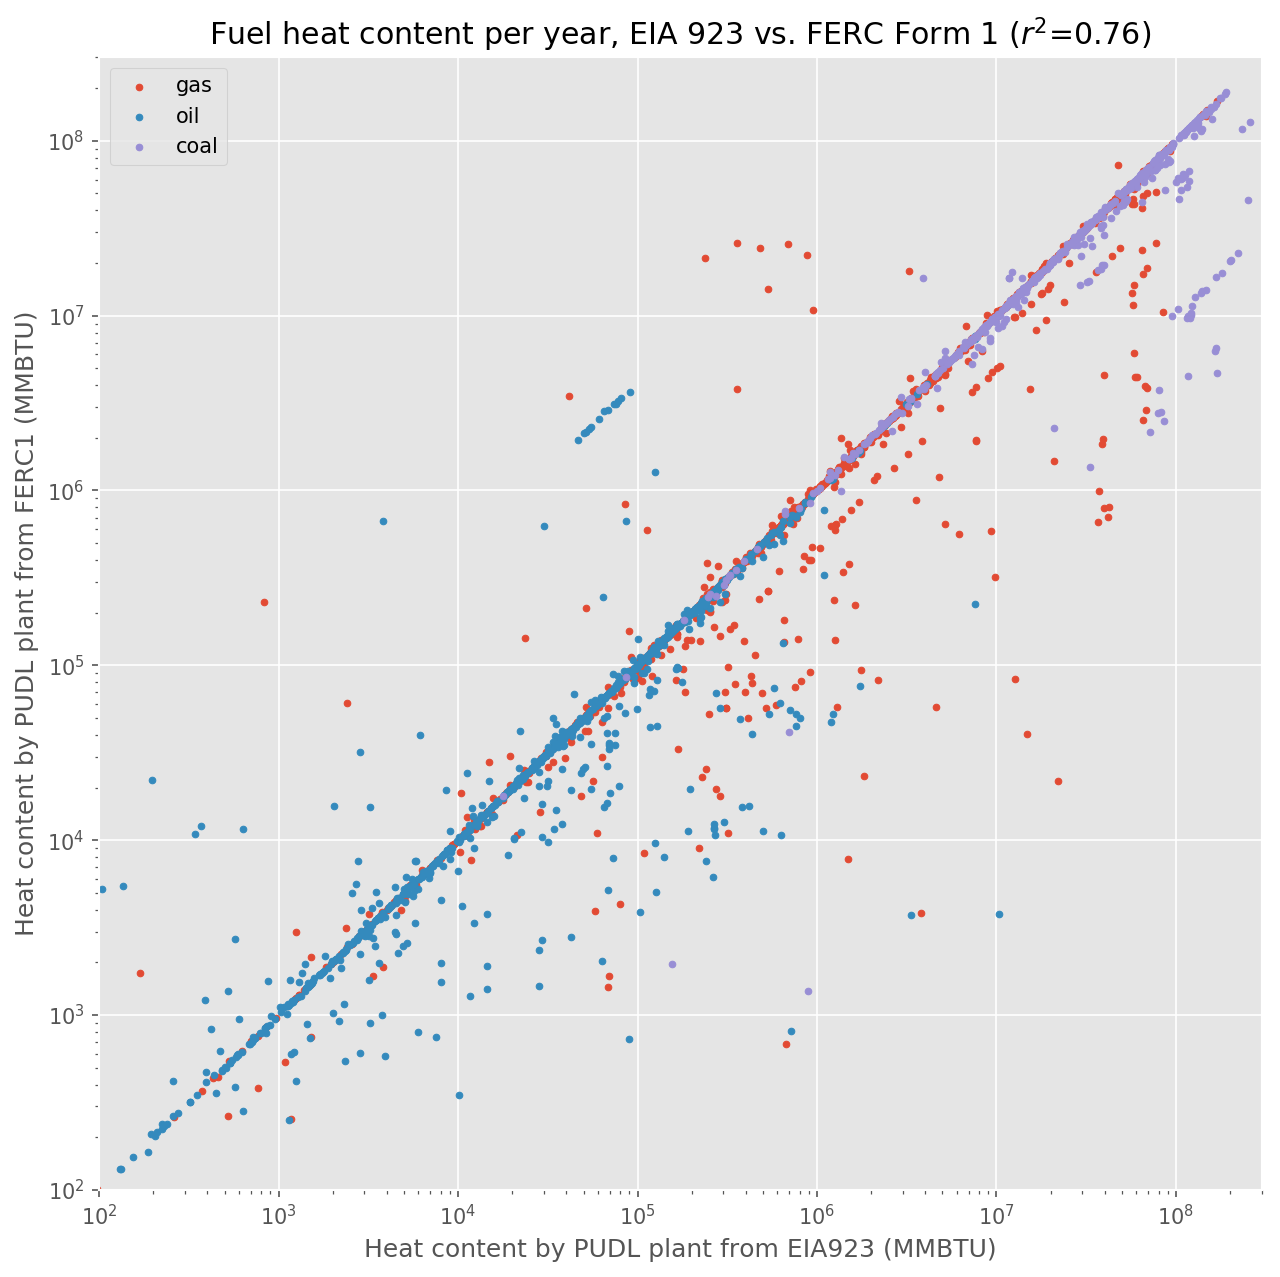

In [16]:
fig, (ax) = plt.subplots(ncols=1, nrows=1)
fig.set_figwidth(10)
fig.set_figheight(10)
fig.set_dpi(150)
ax.loglog()
plt.ylim(100,3e8)
plt.xlim(100,3e8)
plt.grid(b=True)
for fuel in fuels:
    ax.scatter(fuel_eia923_ferc1[(fuel_eia923_ferc1.fuel==fuel)]['mmbtu_eia923'],
               fuel_eia923_ferc1[(fuel_eia923_ferc1.fuel==fuel)]['mmbtu_ferc1'],
               label=fuel, s=10)
ax.legend(loc='upper left')
R2 = np.corrcoef(fuel_eia923_ferc1.mmbtu_eia923, fuel_eia923_ferc1.mmbtu_ferc1)[0,1]**2
plt.title("Fuel heat content per year, EIA 923 vs. FERC Form 1 ($r^2$={:.2f})".format(R2))
plt.xlabel("Heat content by PUDL plant from EIA923 (MMBTU)")
plt.ylabel("Heat content by PUDL plant from FERC1 (MMBTU)")
plt.show();

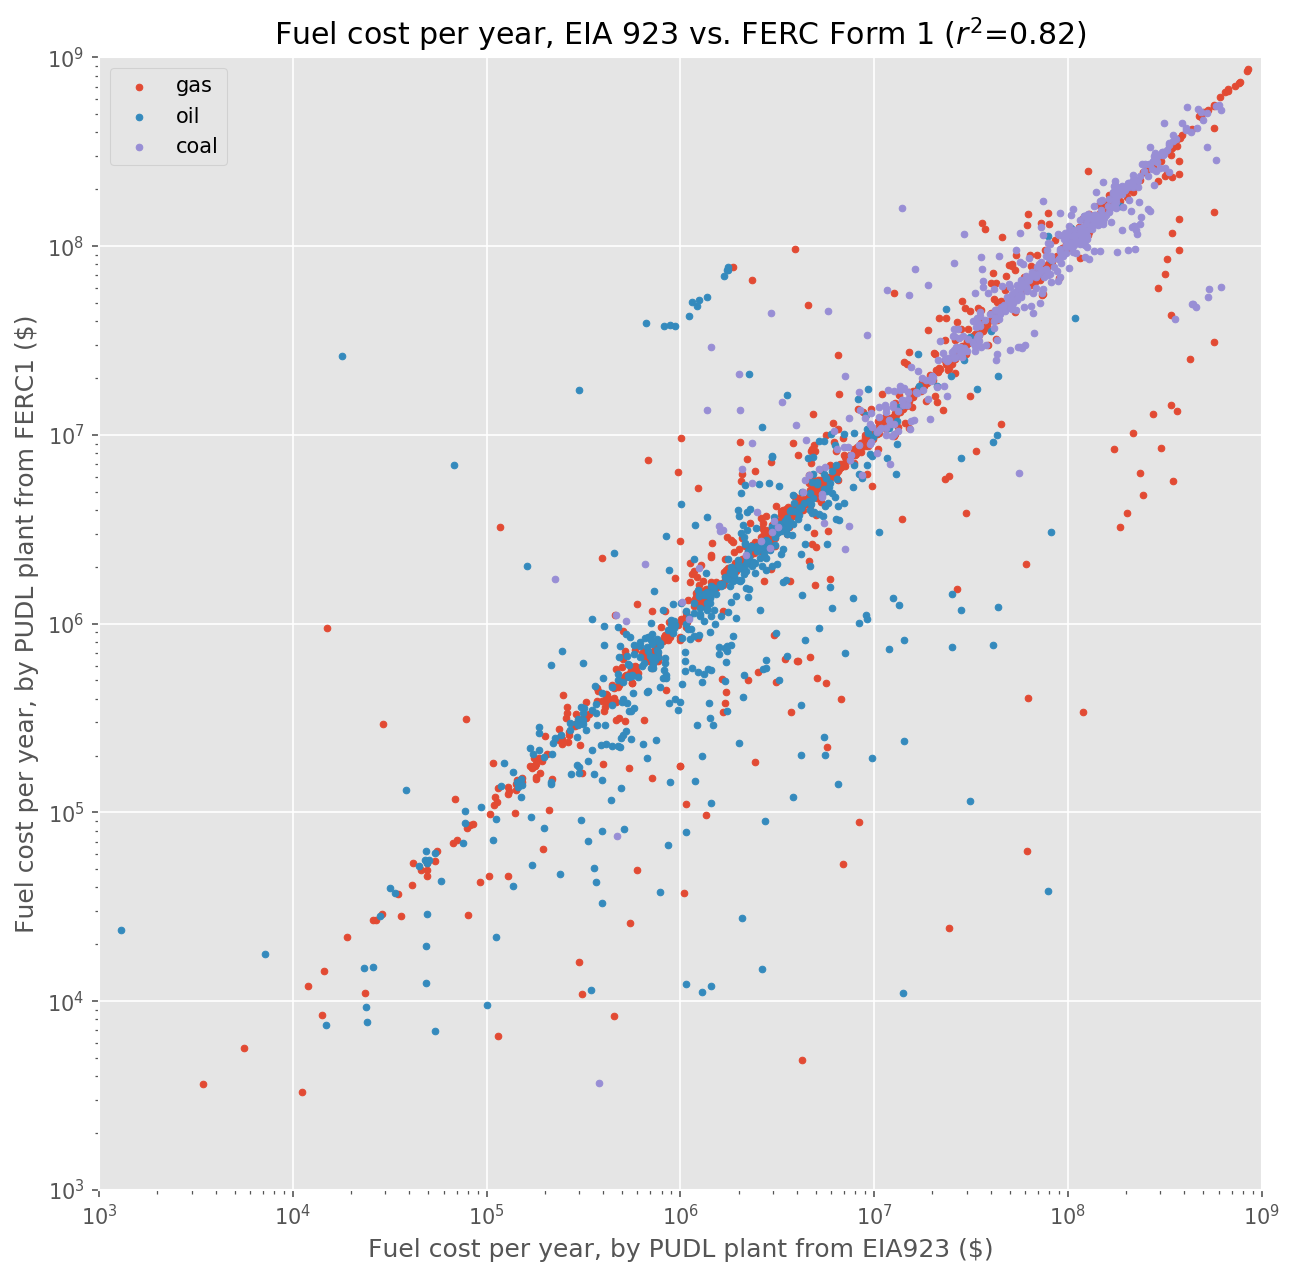

In [17]:
fig, (ax) = plt.subplots(ncols=1, nrows=1)
fig.set_figwidth(10)
fig.set_figheight(10)
fig.set_dpi(150)
ax.loglog()
plt.ylim(1e3,1e9)
plt.xlim(1e3,1e9)
plt.grid(b=True)
for fuel in fuels:
    ax.scatter(cost_eia923_ferc1[(cost_eia923_ferc1.fuel==fuel)]['cost_eia923'],
               cost_eia923_ferc1[(cost_eia923_ferc1.fuel==fuel)]['cost_mmbtu_ferc1'],
               label=fuel, s=10)
ax.legend(loc='upper left')
R2 = np.corrcoef(cost_eia923_ferc1.cost_eia923, cost_eia923_ferc1.cost_mmbtu_ferc1)[0,1]**2
plt.title("Fuel cost per year, EIA 923 vs. FERC Form 1 ($r^2$={:.2f})".format(R2))
plt.xlabel("Fuel cost per year, by PUDL plant from EIA923 ($)")
plt.ylabel("Fuel cost per year, by PUDL plant from FERC1 ($)")
plt.show();

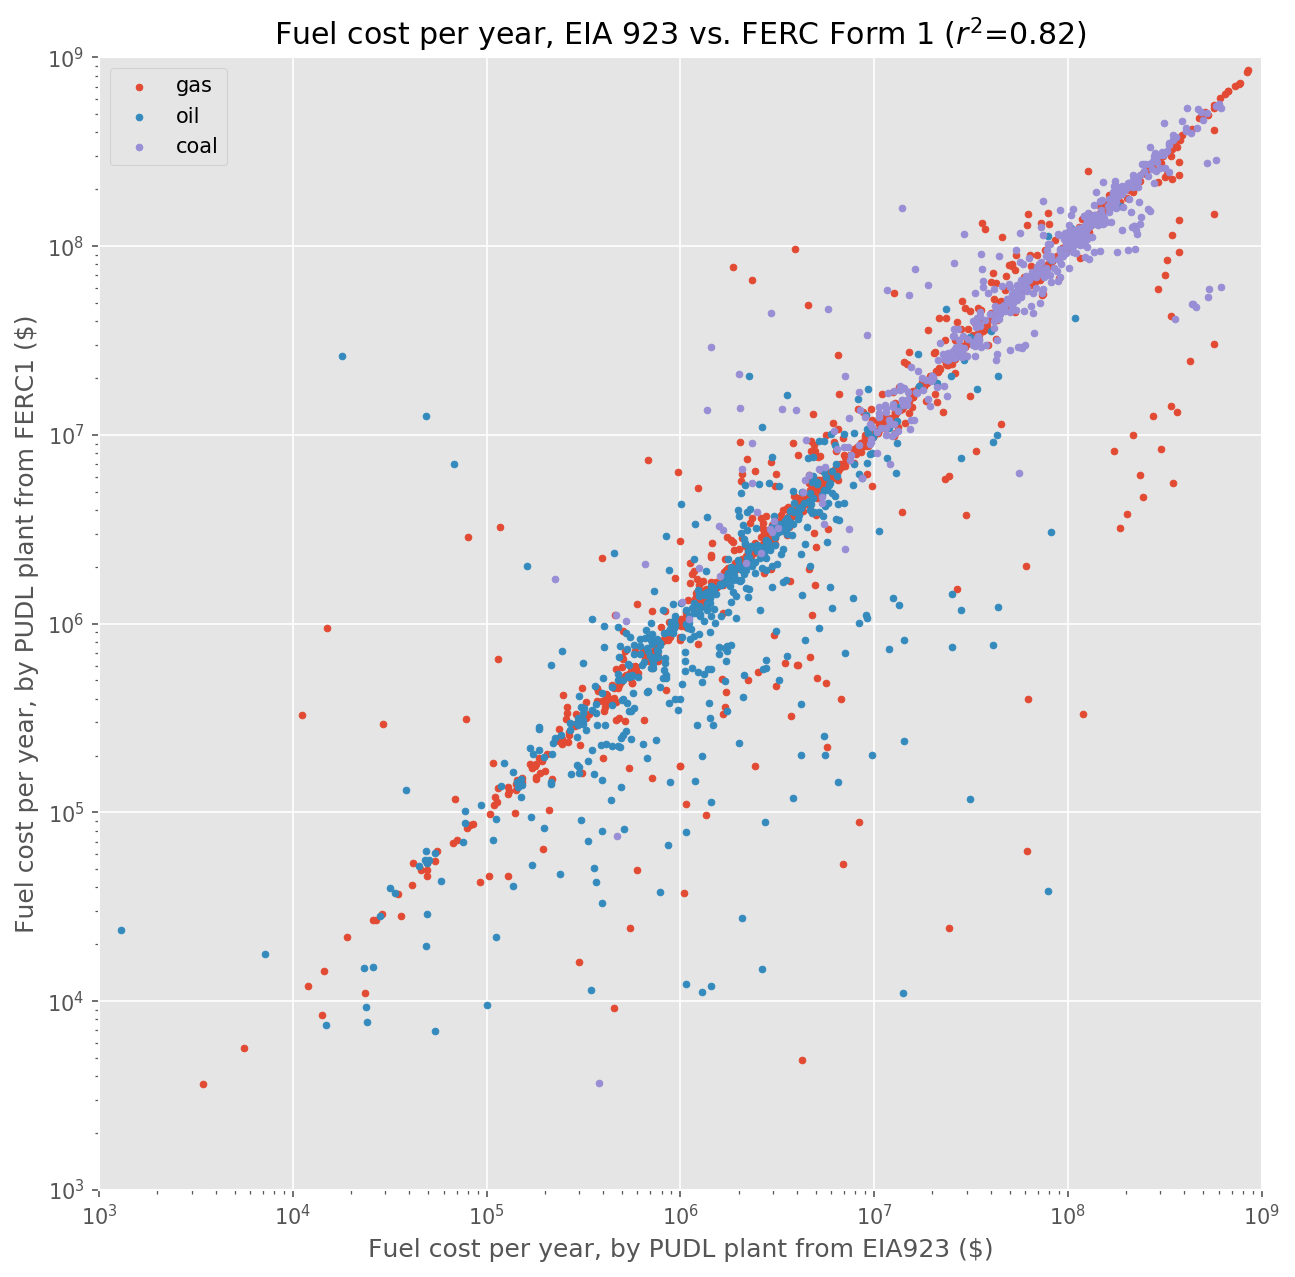

In [18]:
fig, (ax) = plt.subplots(ncols=1, nrows=1)
fig.set_figwidth(10)
fig.set_figheight(10)
fig.set_dpi(150)
ax.loglog()
plt.ylim(1e3,1e9)
plt.xlim(1e3,1e9)
plt.grid(b=True)
for fuel in fuels:
    ax.scatter(cost_eia923_ferc1[(cost_eia923_ferc1.fuel==fuel)]['cost_eia923'],
               cost_eia923_ferc1[(cost_eia923_ferc1.fuel==fuel)]['cost_unit_ferc1'],
               label=fuel, s=10)
ax.legend(loc='upper left')
R2 = np.corrcoef(cost_eia923_ferc1.cost_eia923, cost_eia923_ferc1.cost_unit_ferc1)[0,1]**2
plt.title("Fuel cost per year, EIA 923 vs. FERC Form 1 ($r^2$={:.2f})".format(R2))
plt.xlabel("Fuel cost per year, by PUDL plant from EIA923 ($)")
plt.ylabel("Fuel cost per year, by PUDL plant from FERC1 ($)")
plt.show();

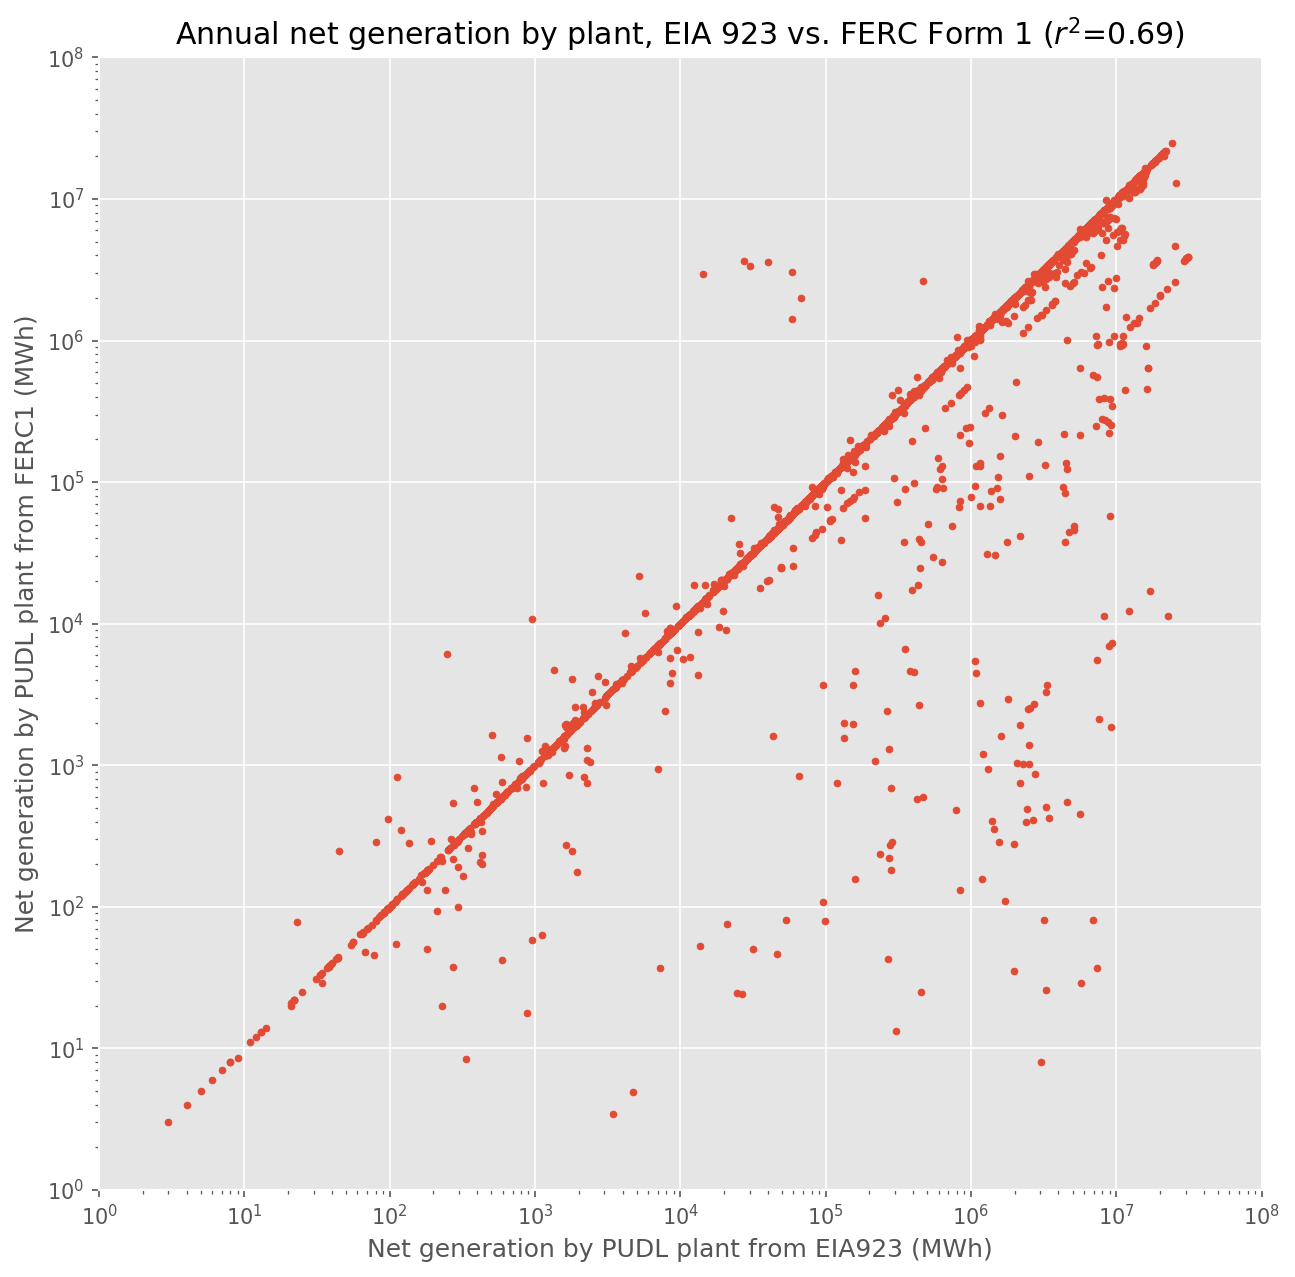

In [19]:
fig, (ax) = plt.subplots(ncols=1, nrows=1)
fig.set_figwidth(10)
fig.set_figheight(10)
fig.set_dpi(150)
ax.loglog()
plt.ylim(1,1e8)
plt.xlim(1,1e8)
plt.grid(b=True)
R2 = np.corrcoef(netgen_eia923_ferc1.mwh_eia923, netgen_eia923_ferc1.mwh_ferc1)[0,1]**2
ax.scatter(netgen_eia923_ferc1['mwh_eia923'],
           netgen_eia923_ferc1['mwh_ferc1'],
           s=10)
plt.title("Annual net generation by plant, EIA 923 vs. FERC Form 1 ($r^2$={:.2f})".format(R2))
plt.xlabel("Net generation by PUDL plant from EIA923 (MWh)")
plt.ylabel("Net generation by PUDL plant from FERC1 (MWh)")
plt.show();

# Plant-by-Plant Correlations
Given that the entire datasets seem to correlate pretty well, now we want to look at each plant individually, and see whether it is easy to identify well an poorly matched plants.

In [20]:
def plant_corr(pudl_df, x1, x2):
    gb = pudl_df.groupby('plant_id_pudl')
    corr = gb[[x1,x2]].corr().reset_index()
    corr = corr.drop(x2, axis=1)
    corr = corr[corr['level_1']==x2]
    corr = corr[['plant_id_pudl',x1]]
    corr = corr.rename(columns={x1:'corr'})
    corr = corr.dropna()
    return(corr)

def plot_plant_corr(corrs=[], titles=[]):
    """Given a list of DataFrames containing per-plant correlations of some variable,
    and a set of associated figure titles, create a figure displaying the distributions
    of those correlations."""
    
    nrows = len(corrs)
    assert nrows == len(titles)
    fig, axes = plt.subplots(ncols=1, nrows=nrows)
    fig.set_figwidth(10)
    fig.set_figheight(4*nrows)
    fig.set_dpi(150)
    for (ax, title, corr) in zip(axes, titles, corrs):
        ax.set_xlim(0.0,1.1)
        ax.set_title(title)
        ax.set_ylabel("# of Plants")
        ax.set_xlabel("$R^2$")
        ax.grid(b=True)
        ax.hist(corr['corr']**2, bins=250);
    fig.tight_layout()
    plt.show()

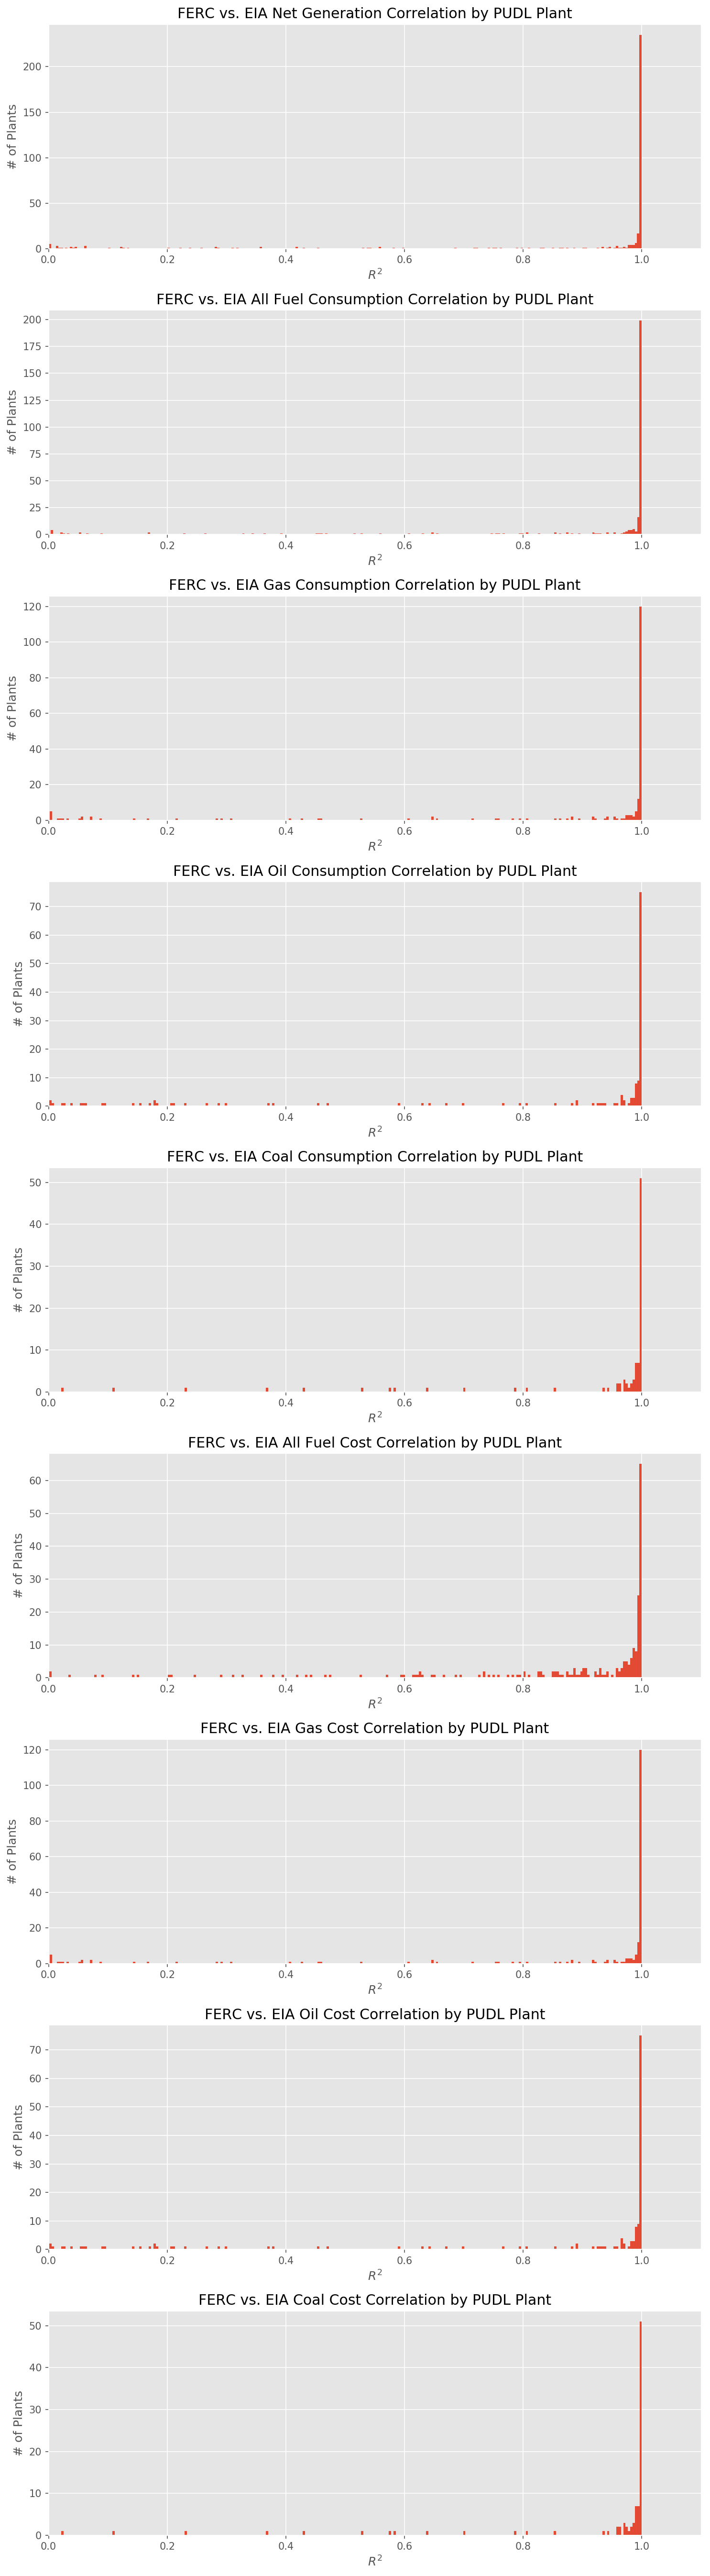

In [21]:
netgen_corr = plant_corr(netgen_eia923_ferc1, 'mwh_eia923', 'mwh_ferc1')
fuel_corr = plant_corr(fuel_eia923_ferc1, 'mmbtu_eia923', 'mmbtu_ferc1')

gas_fuel_corr = plant_corr(fuel_eia923_ferc1[fuel_eia923_ferc1['fuel']=='gas'], 'mmbtu_eia923', 'mmbtu_ferc1')
oil_fuel_corr = plant_corr(fuel_eia923_ferc1[fuel_eia923_ferc1['fuel']=='oil'], 'mmbtu_eia923', 'mmbtu_ferc1')
coal_fuel_corr = plant_corr(fuel_eia923_ferc1[fuel_eia923_ferc1['fuel']=='coal'], 'mmbtu_eia923', 'mmbtu_ferc1')

cost_corr = plant_corr(cost_eia923_ferc1, 'cost_eia923','cost_mmbtu_ferc1')

gas_cost_corr = plant_corr(cost_eia923_ferc1[cost_eia923_ferc1['fuel']=='gas'], 'cost_eia923', 'cost_mmbtu_ferc1')
oil_cost_corr = plant_corr(cost_eia923_ferc1[cost_eia923_ferc1['fuel']=='oil'], 'cost_eia923', 'cost_mmbtu_ferc1')
coal_cost_corr = plant_corr(cost_eia923_ferc1[cost_eia923_ferc1['fuel']=='coal'], 'cost_eia923', 'cost_mmbtu_ferc1')

corrs = [netgen_corr,
         fuel_corr,
         gas_fuel_corr,
         oil_fuel_corr,
         coal_fuel_corr,
         cost_corr,
         gas_fuel_corr,
         oil_fuel_corr,
         coal_fuel_corr]
titles = ['FERC vs. EIA Net Generation Correlation by PUDL Plant',
          'FERC vs. EIA All Fuel Consumption Correlation by PUDL Plant',
          'FERC vs. EIA Gas Consumption Correlation by PUDL Plant',
          'FERC vs. EIA Oil Consumption Correlation by PUDL Plant',
          'FERC vs. EIA Coal Consumption Correlation by PUDL Plant',
          'FERC vs. EIA All Fuel Cost Correlation by PUDL Plant',
          'FERC vs. EIA Gas Cost Correlation by PUDL Plant',
          'FERC vs. EIA Oil Cost Correlation by PUDL Plant',
          'FERC vs. EIA Coal Cost Correlation by PUDL Plant']
plot_plant_corr(corrs, titles)